In [189]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import stylecloud
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

In [190]:
reddit = praw.Reddit(client_id='Uqa0qPvYrRATm6WB2yy6vw', client_secret='ExLLWnJZrEJ5XrSdU9GQ074YOoOg5A', user_agent='sentiment')

In [191]:
def get_whole_thread(submission):
    # d = {}
    comments = []
    for top_level_comment in submission.comments:
        # print("COMMENT:")
        # print(top_level_comment.body)
        # d[top_level_comment.body] = []
        comments.append(top_level_comment.body)
        replies = []
        replies.extend(top_level_comment.replies)
        while replies:
            reply = replies.pop(0)
            if isinstance(reply, MoreComments):
                continue
            # print("    SUBCOMMENT:")
            # print(reply.body)
            # d[top_level_comment.body].append(reply.body)
            comments.append(reply.body)
            # print("________")
            replies = list(reply.replies) + replies
    return comments

In [192]:
subreddit = reddit.subreddit("SGExams")
cnt = 0
posts = []
print("start")
for submission in subreddit.search("smu cs"):
    post = []
    post.append(submission.title)
    post.append(submission.selftext)
    comments = get_whole_thread(submission)
    post.append(comments)
    posts.append(post)

print('end')

start
end


In [193]:
df = pd.DataFrame(posts,columns=['title', 'body', 'comments'])
# print(df)
# df.to_csv("reddit_sg_exams.csv", sep='\t')
df.head()

,title,body,comments
0,[uni] SMU CS discovery day,got an acceptance email tdy for SMU CS saying ...,"[wat ur rp?, 82.5, I was equally as surprised ..."
1,[Uni] SMU cs or NUS cs,"\n\nHello, i’m looking to apply for my uni cou...","[Tbh and no offense to OP, I keep seeing these..."
2,[uni] SMU CS vs IS,"hi there, i just wanted to ask any students in...","[>hey ! current smu cs student, imo the resour..."
3,[UNI] How is SMU CS like?,Got rejected by NTU and NUS... I have attended...,[I would like to know too I’m thinking of join...
4,[Uni] SMU CS vs NTU CS,"Hey, anyone able to shed some light on SMU Com...",[Im unable to comment on SMU CS but I'm able t...


In [194]:
#Show the Titles that contain NTU
# qn_content = ''
# for line in df['title']:
#     if 'ntu' in line.lower():   
#         print(line)

In [195]:
#Show the titles that contain NTU, CS, SMU and not transfer (transfer thread not relevant to outreach)
only_ntu = df[df['title'].str.contains('NTU')]
for line in only_ntu['title']:
    if 'ntu' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower() and 'transfer' not in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)

[Uni] SMU CS vs NTU CS
[A levels] NTU CS /NTU CE and SMU IS/SMU CS
[Uni] NTU business and computing and SMU CS+BIZ
[Uni] SMU CS or NTU CE
[A levels] SMU IS vs SIT CS vs NTU CE vs SUTD ISTD
[Uni] What are the job prospects of a biz degree? Should I study biz at NUS or CS at NTU/SMU?
[Uni] I need some help in choosing uni course. NTU or SMU for CS? seniors please give me your input!!


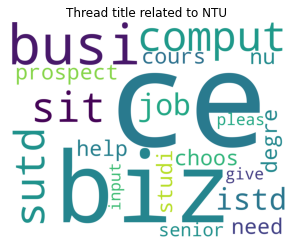

In [196]:
#Cloud word for titles that contain NTU, SMU CS

stop_words = stopwords.words('english')
stop_words.extend(['ntu', 'uni', 'smu', 'cs', 'vs', 'level', 'levels'])

qn_content = ''
for line in df['title']:
    if 'ntu' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower() and 'transfer' not in line.lower():
        qn_content += line.lower() + ' '    
        #print(line)

# Tokenize Words
tokenizer = RegexpTokenizer(r'\w+')
words_content = tokenizer.tokenize(qn_content)  # All answers for that question into words

# Remove stop words
words_filtered = []
for w in words_content:
    if w not in stop_words:
        words_filtered.append(w)

# Porter Stemmer
porter_stemmer = PorterStemmer()

words_stemmed = []
for w in words_filtered:
    words_stemmed.append(porter_stemmer.stem(w))

# WordCloud
words_joined = " ".join([w for w in words_stemmed])

# Create a word cloud
my_wordcloud = WordCloud(background_color='white',
                     width=1800,
                     height=1400).generate(words_joined)

plt.imshow(my_wordcloud)
plt.axis('off')
plt.title('Thread title related to NTU')
plt.show()

In [197]:
only_ntu = df[df['title'].str.contains('NTU')]
only_ntu.head()

,title,body,comments
4,[Uni] SMU CS vs NTU CS,"Hey, anyone able to shed some light on SMU Com...",[Im unable to comment on SMU CS but I'm able t...
5,[A levels] NTU CS /NTU CE and SMU IS/SMU CS,So I got 75rp and can't go to NTU/SMU CS so I ...,[Go to NTU CE or SIT UOG if you really want to...
12,[Uni] NTU business and computing and SMU CS+BIZ,Hi all would need some advice on these choices...,"[[deleted], I havent seen anyone below 80, I h..."
14,[Uni] SMU CS or NTU CE,I just received admissions from these two Univ...,"[[deleted], Care to explain?]"
19,[UNI] NUS CS VS NTU CN YANG SCHOLARS PROGRAMME...,Hi! I would like to know whether I should cho...,[go cnyang if you want to do research. If unsu...


In [198]:
# original stopwords
def original_stopwords():
    return stopwords.words('english')

In [199]:
def extract_text(df):
    for(columnName, columnData) in df.iteritems():
        qn_content = []
        for line in df[columnName]:
            if len(line.strip()) > 0: # Eliminates empty answers
                qn_content.append(line)
    return qn_content

In [262]:
# Helper Function for Tokenisation of text content, returns a list of word or words depending on ngrams defined
def token_fn(sentence_list, n, stop_words_custom):
    output = []
    for line in sentence_list:
        #print(line , ' line')
        token = word_tokenize(line)
        
        #print(token , ' token')
        gram = list(ngrams(token, n))
        
      #  print(gram , ' gram')
        
        if n == 1:
            for content in gram:
                for word in content:
                    if word not in stop_words_custom:
                        output.append(word)   
        else:
            for content in gram:
                link = ''
                for word in content:
                    link += word + '_'
                link = link[:-1]
                output.append(link)
        
    #print(" test " , output)
    return output

# Helper Function for Stemming using Porter Stemmer, returns a list of stemmed words
# def stem_fn(word_list):
#     porter_stemmer = PorterStemmer()
#     words_stemmed = []
#     for w in words_list:
#         words_stemmed.append(porter_stemmer.stem(w))
    
#     return words_stemmed

# Helper Function for Word Cloud Generation
def wc_fn(word_list, title, no_word_max):
    #print(word_list , 'wc_fn')
    words_joined = " ".join([w for w in word_list])
    my_wordcloud = WordCloud(background_color='white', max_words = no_word_max, 
                             max_font_size = 1000,
                             width=2500,
                             height=1400).generate(words_joined)
    plt.imshow(my_wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

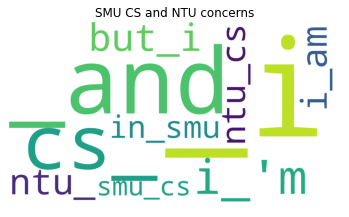

In [266]:
# # Top commmon body for SMU & NTU

# Top commmon comments for SMU & NTU

smu_ntu_body = only_ntu.iloc[:, [1]]
#print(smu_ntu_comments)

sw = original_stopwords()
sw.extend(['seem', 'biz' , 'go', 'school' , 'coding', 'computing', 'nus', 'year', 'course' , 'courses','hi', 'ntu', 'tat', 'much', 'able', 'cs','want', 'smu', 'sure', 'im', 'thank', 'based', 'city', 'really', 
           'if' , ' for' , 'but' , 'in', 'the', 'you', 'it', "i'm" ,'rank', 'points', 'lol', 'bro', 'cmi', 'hahah' , 'i' , 'but' ,
           'and', 'one', 'well', 'but_i', 'i_am'])

sentences = []
for sentence in smu_ntu_body["body"]:
#     for comment in commentArray:
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower() :
        sentences.append(sentence.lower())

        # Eliminates empty answers
#single_word = token_fn(sentences, 1, sw)

double_word = token_fn(sentences, 2, sw)
#print(double_word , 'hereeeeeeeeeeeeee' )
# triple_word = token_fn(sentences, 3, sw)

# wc_fn(single_word, 'SMU CS and NTU concerns', 80)
wc_fn(double_word, 'SMU CS and NTU concerns', 10)
# wc_fn(triple_word, 'SMU CS and NTU concerns', 25)

#stylecloud
# sc_words = " ".join([w.upper() for w in single_word])
# sc_words_2 = " ".join([w.upper() for w in double_word])
# sc_words_3 = " ".join([w.upper() for w in triple_word])

# stylecloud.gen_stylecloud(sc_words,
#                           icon_name = 'fas fa-question',
#                           palette ='cartocolors.qualitative.Bold_8',
#                           background_color = 'black',
#                           output_name ='smu_ntu_concerns_single.png',
#                           collocations = False,
#                           custom_stopwords = sw)

# stylecloud.gen_stylecloud(sc_words_2,
#                           icon_name = 'fas fa-question',
#                           palette ='cartocolors.qualitative.Bold_8',
#                           background_color = 'black',
#                           output_name ='smu_ntu_concerns_double.png',
#                           collocations = False,
#                           custom_stopwords = sw)

# stylecloud.gen_stylecloud(sc_words_3,
#                           icon_name = 'fas fa-question',
#                           palette ='cartocolors.qualitative.Bold_8',
#                           background_color = 'black',
#                           output_name ="smu_ntu_concerns_triple.png",
#                           collocations = False,
#                           custom_stopwords = sw)
                          
## References ###
# icon_name: https://fontawesome.com/
# palette: https://jiffyclub.github.io/palettable/cartocolors/qualitative/


# From single word WC: Probably related to the skills / majors that are offered SCIS
# From double & triple word WC: SCIS offers industry-based and practical skills, Less technical or more-friendly degrees
# as well as smart-city management

In [260]:
# Helper Function for Tokenisation of text content, returns a list of word or words depending on ngrams defined
def token_fn2(sentence_list, n, stop_words_custom):
    output = []
    output2 = []
    for line in sentence_list:
        x = line.split()
        #print(x)
        
        for word in x:
            #print(word)
            if word not in stop_words_custom:
                #print(word)
                output.append(word)
    
        sentence = ""
        for word in output:
            sentence += word + " "
            
        token = word_tokenize(sentence)
        gram = list(ngrams(token, n))
        
        if n == 1:
            for content in gram:
                for word in content:
                    output2.append(word)  
        else:
            for content in gram:
                link = ''
                for word in content:
                    link += word + '_'
                link = link[:-1]
                output2.append(link)

    #print(output2, 'output2')
#     print(gram , 'gram')
    return output2

def wc_fn(word_list, title, no_word_max):
    words_joined = " ".join([w for w in word_list])
    my_wordcloud = WordCloud(background_color='white', max_words = no_word_max, 
                             max_font_size = 1000,
                             width=2500,
                             height=1400).generate(words_joined)
    plt.imshow(my_wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

['anyone_able', 'able_shed', 'shed_light', 'light_comp', 'comp_sci', 'sci_vs', 'vs_ntu', 'ntu_comp', 'comp_sci', 'sci_?', '?_right', 'right_bat', 'bat_,', ',_ntu', "ntu_'s", "'s_curriculum", "curriculum_'heavier", "'heavier_'", "'_compared", 'compared_boil', 'boil_that', 'that_?', '?_&', '&_#', '#_x200b', 'x200b_;', ';_\\-', '\\-_two', 'two_universities', 'universities_mind', 'mind_now', 'now_,', ',_currently', 'currently_year', 'year_3', '3_sem', 'sem_2', '2_gpa', 'gpa_3.90', '3.90_.', '._\\-', '\\-_offered', 'offered_early', 'early_admission', 'admission_cs', 'cs_.', '._news', 'news_ntu', 'ntu_yet', 'yet_.', 'anyone_able', 'able_shed', 'shed_light', 'light_comp', 'comp_sci', 'sci_vs', 'vs_ntu', 'ntu_comp', 'comp_sci', 'sci_?', '?_right', 'right_bat', 'bat_,', ',_ntu', "ntu_'s", "'s_curriculum", "curriculum_'heavier", "'heavier_'", "'_compared", 'compared_boil', 'boil_that', 'that_?', '?_&', '&_#', '#_x200b', 'x200b_;', ';_\\-', '\\-_two', 'two_universities', 'universities_mind', 'min

  double word


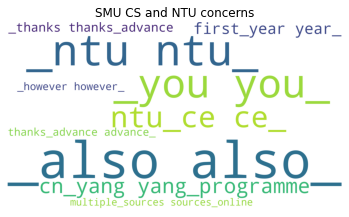

In [265]:
# # Top commmon body for SMU & NTU

smu_ntu_body = only_ntu.iloc[:, [1]]

sw = original_stopwords()
sw.extend(['nt', "n't",'rlly','hi', 'tat', 'much', 'cs', 'smu', 'sure', 'im', 'thank', 'based', 'city', 'really', 
           'if' , ' for' , 'but' , 'in', 'the', 'you', 'it', "i'm", 'lol', 'bro', 'cmi', 'hahah' , 'i' , 'but' ,
           'and', 'one', 'well', 'hey', 'hey,'])

sentences = []
for sentence in smu_ntu_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower():
        sentences.append(sentence.lower())
    
    
#single_word = token_fn2(sentences, 1, sw)
# wc_fn(single_word, 'SMU CS and NTU concerns', 10)

double_word = token_fn2(sentences, 2, sw)
print(double_word , ' double word')
wc_fn(double_word, 'SMU CS and NTU concerns', 10)


In [227]:
# #Total number of insights
# smu_ntu_comments = only_ntu.iloc[:, [2]]

# sentences = []
# noOfThread = 0
# totalComments = 0
# for commentArray in smu_ntu_comments["comments"]:
#     noOfThread += 1
#     valueArray = 0
#     for comment in commentArray:
#         valueArray += 1
#         totalComments += 1

# print(noOfThread , ' noOfThread')
# print(totalComments , ' totalComments')
# print('Average comment per thread: ' , totalComments/noOfThread)

In [269]:
def original_stopwords():
    return stopwords.words('english')

sw = original_stopwords()
sw.extend(['nt', "n't",'rlly','hi', 'tat', 'much', 'cs', 'smu', 'sure', 'im', 'thank', 'based', 'city', 'really', 
           'if' , ' for' , 'but' , 'in', 'the', 'you', 'it', "i'm", 'lol', 'bro', 'cmi', 'hahah' , 'i' , 'but' ,
           'and', 'one', 'well', 'hey', 'hey,'])

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '